## ML3 - Machine Learning in Practice; Generalization

#### Goals
* Be able to build and train a simple multi-layer perceptron neural network in `pytorch`
* Understand what it means for a model to **generalize**
* Know how and why to prevent **overfitting** by splitting the dataset into training and validation sets
* Know how and why to hold out a test set
* Have a basic understanding of bias and variance as they relate to underfitting and overfitting

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device('cuda') # nvidia/cuda
elif torch.mps.is_available():
    device = torch.device('mps') # apple
else:
    device = torch.device('cpu') # no acceleration

print(f'Using device: {device}')

Using device: mps


### Autograd in pytorch:

Generate some data:

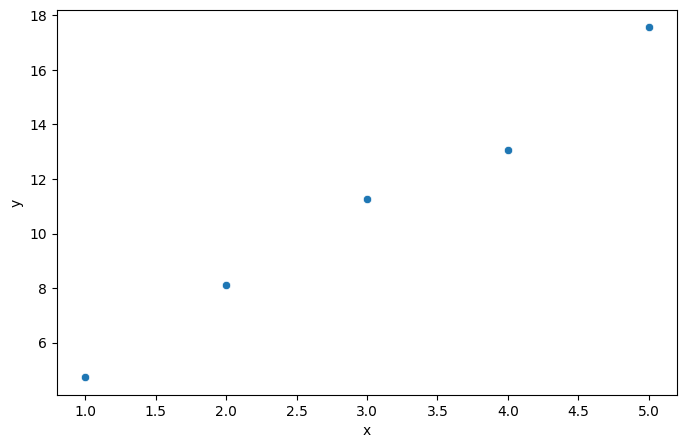

In [2]:
# Set random seed for reproducibility
torch.manual_seed(41)
np.random.seed(41)

x_np = np.array([1.0, 2.0, 3.0, 4.0, 5.0])
y_true_np = 3.0 * x_np + 2.0
noise = np.random.randn(5) * 1.0
y_np = y_true_np + noise

# Visualize the data
plt.figure(figsize=(8, 5))
sns.scatterplot(x=x_np, y=y_np)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [9]:
print(f"Data points (x, y):")
for i in range(5):
    print(f"  ({x_np[i]:.1f}, {y_np[i]:.2f})")

# Convert to PyTorch tensors
x = torch.from_numpy(x_np).float()
y = torch.from_numpy(y_np).float()

# Parameters (requires_grad=True enables autograd)
w = torch.tensor(0.0, requires_grad=True)
b = torch.tensor(0.0, requires_grad=True)

# Forward pass: compute prediction
y_pred = w * x + b

# Compute loss (MSE)
loss = ((y_pred - y) ** 2).mean()

print(w.grad)
print(b.grad)

# Backward pass: compute gradients
loss.backward()

# print(f"Prediction: {y_pred.item()}")
print(f"Loss: {loss.item()}")
print(f"Gradient w.r.t. w: {w.grad.item()}")
print(f"Gradient w.r.t. b: {b.grad.item()}")

Data points (x, y):
  (1.0, 4.73)
  (2.0, 8.10)
  (3.0, 11.25)
  (4.0, 13.07)
  (5.0, 17.57)
None
None
Loss: 138.83682250976562
Gradient w.r.t. w: -77.9301986694336
Gradient w.r.t. b: -21.890644073486328


Let's check if we agree with pytorch - these are the analytical gradients we computed in ML1:

In [10]:
def grad_wrt_w(yhat, x, y):
    return (2/len(y)) * np.sum((yhat - y) * x)
    
def grad_wrt_b(yhat, x, y):
    return (2/len(y)) * np.sum(yhat - y)

dw = grad_wrt_w(y_pred.detach().numpy(), x.detach().numpy(), y.detach().numpy())
print(f"Analytical gradient wrt w: {dw}")

db = grad_wrt_b(y_pred.detach().numpy(), x.detach().numpy(), y.detach().numpy())
print(f"Analytical gradient wrt b: {db}")

Analytical gradient wrt w: -77.9301986694336
Analytical gradient wrt b: -21.890644073486328


### Gradient Descent in Pytorch

Now let's see what a gradient descent loop looks like:



Initial: w=0.0000, b=0.0000
Epoch   1: Loss=138.8368, w=0.7793, b=0.2189


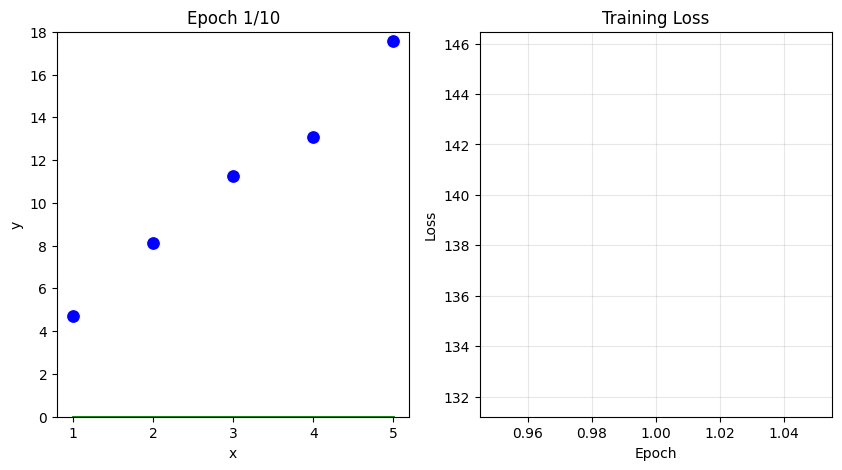

Epoch   2: Loss=81.0656, w=1.3740, b=0.3867


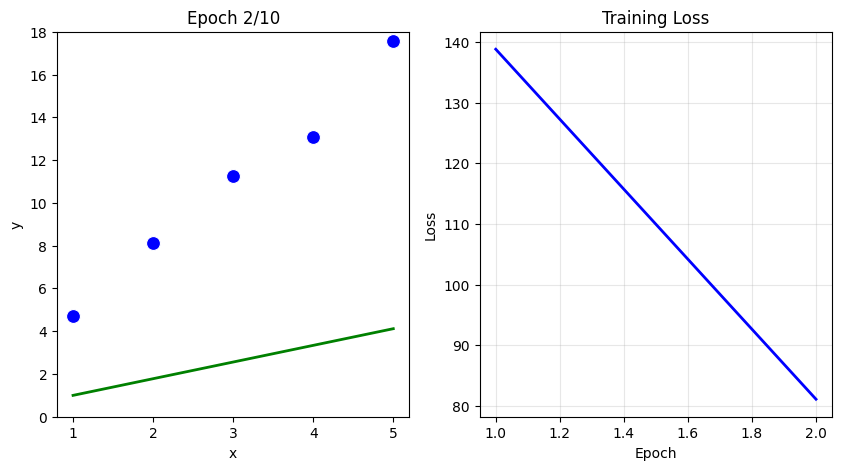

Epoch   3: Loss=47.3990, w=1.8278, b=0.5154


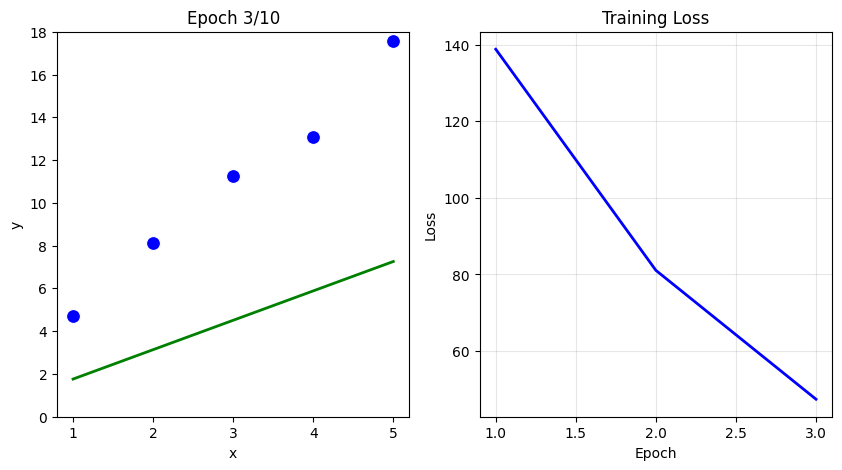

Epoch   4: Loss=27.7794, w=2.1741, b=0.6143


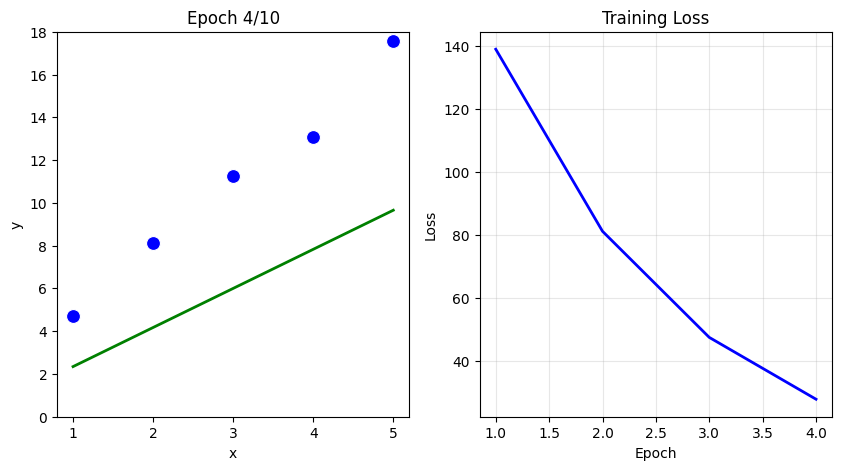

Epoch   5: Loss=16.3458, w=2.4382, b=0.6905


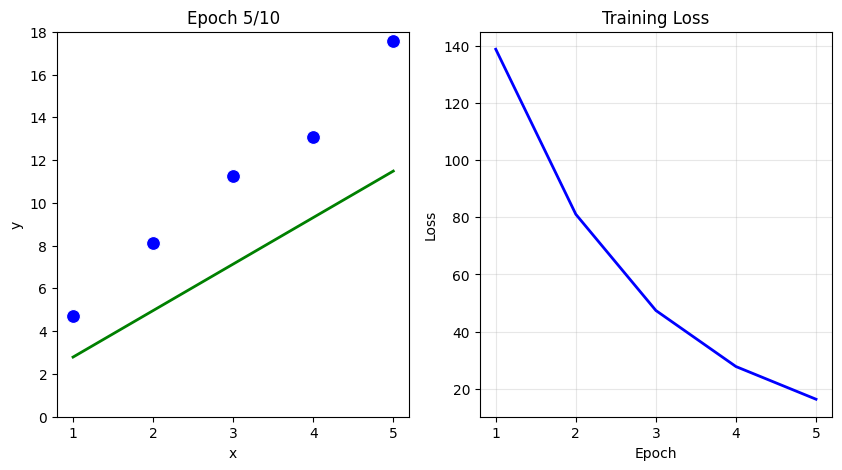

Epoch   6: Loss=9.6824, w=2.6397, b=0.7493


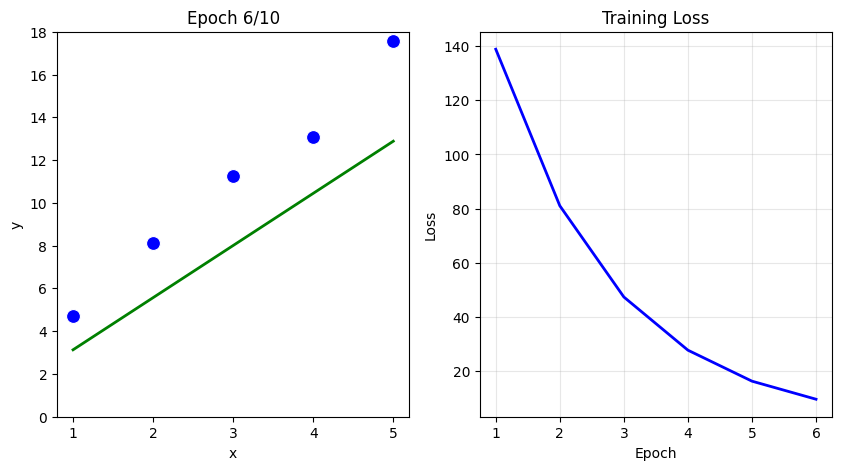

Epoch   7: Loss=5.7990, w=2.7933, b=0.7949


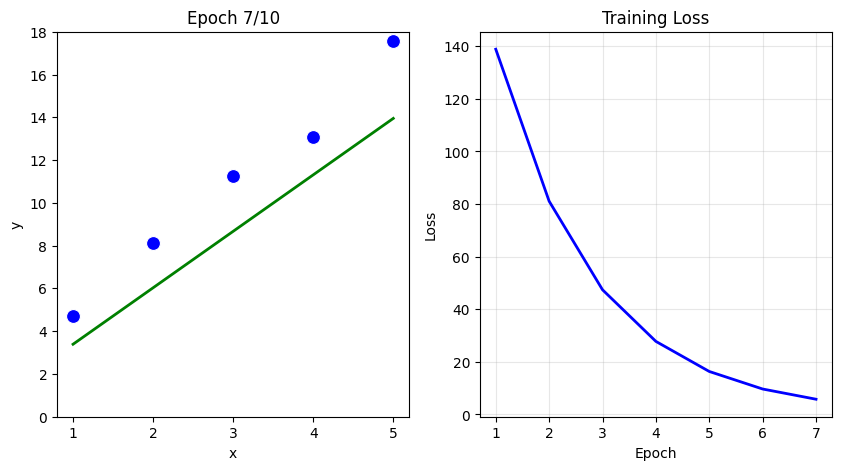

Epoch   8: Loss=3.5356, w=2.9104, b=0.8303


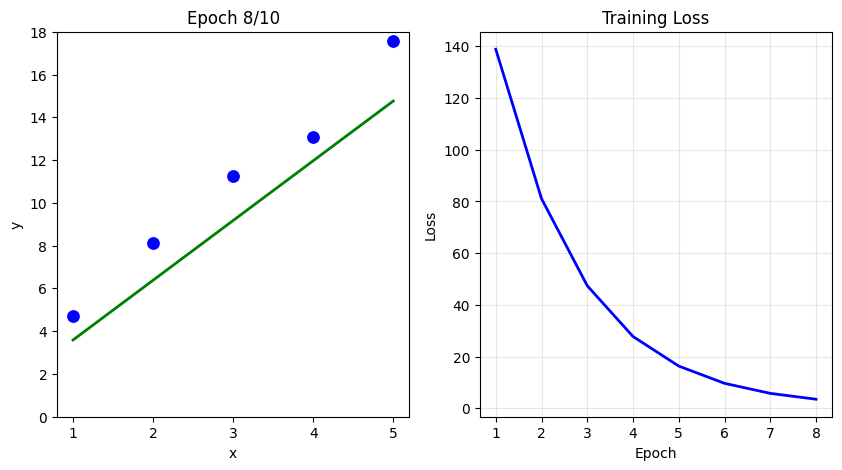

Epoch   9: Loss=2.2163, w=2.9996, b=0.8579


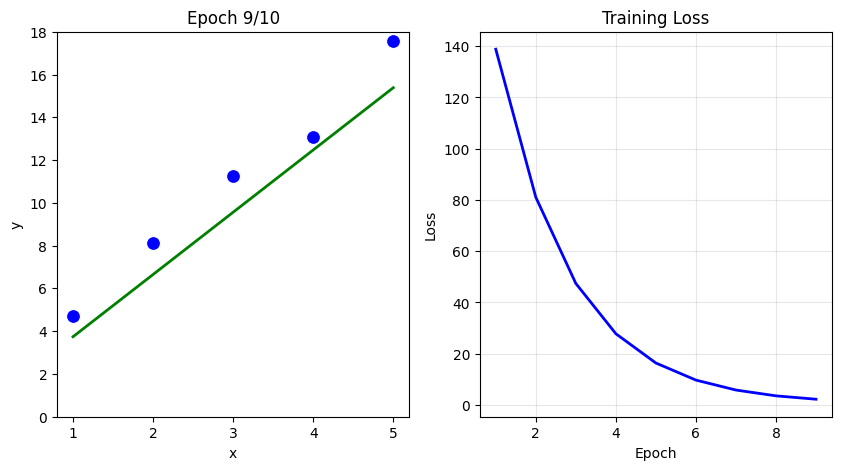

Epoch  10: Loss=1.4471, w=3.0675, b=0.8797


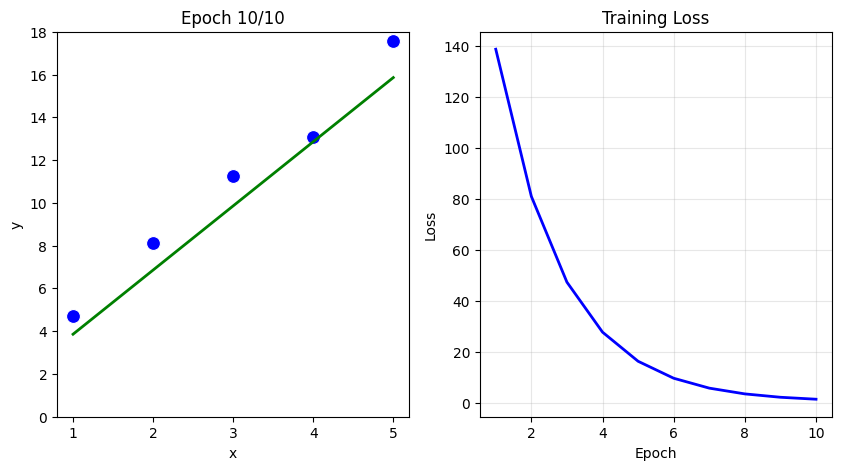

In [11]:
plt.ion()

# Hyperparameters
learning_rate = 0.01
num_epochs = 10

# Parameters (requires_grad=True enables autograd)
w = torch.tensor(0.0, requires_grad=True)
b = torch.tensor(0.0, requires_grad=True)

print(f"Initial: w={w.item():.4f}, b={b.item():.4f}")

# Training loop
for epoch in range(num_epochs):
    # "Forward pass": compute predictions
    y_pred = w * x + b
    
    # Compute loss (MSE)
    loss = ((y_pred - y) ** 2).mean()
    
    # Backward pass: compute gradients with autograd
    loss.backward()
    
    # Manual gradient descent update
    with torch.no_grad():  # Don't track these operations in autograd
        w -= learning_rate * w.grad
        b -= learning_rate * b.grad
    
    # zero out the gradients for next iteration
    w.grad.zero_()
    b.grad.zero_()
    
    # Show progress
    print(f"Epoch {epoch+1:3d}: Loss={loss.item():.4f}, w={w.item():.4f}, b={b.item():.4f}")

    plt.figure(figsize=(10, 5))
    
    # Left plot: Current fit
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=x_np, y=y_np, s=100, color='blue')
    # plt.plot(x_np, y_np, 'r--', alpha=0.5, label='True line (y=3x+2)')
    plt.plot(x_np, y_pred.detach().numpy(), 'g-', linewidth=2, label=f'Current fit (y={w.item():.2f}x+{b.item():.2f})')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Epoch {epoch+1}/{num_epochs}')
    plt.ylim(0, 18)
    
    # Right plot: Loss over time
    if epoch == 0:
        loss_history = [loss.item()]
    else:
        loss_history.append(loss.item())
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(loss_history)+1), loss_history, 'b-', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True, alpha=0.3)
    plt.show()
    import time
    time.sleep(1)
    

## Part 1: Load CIFAR-10 and Display Sample Images

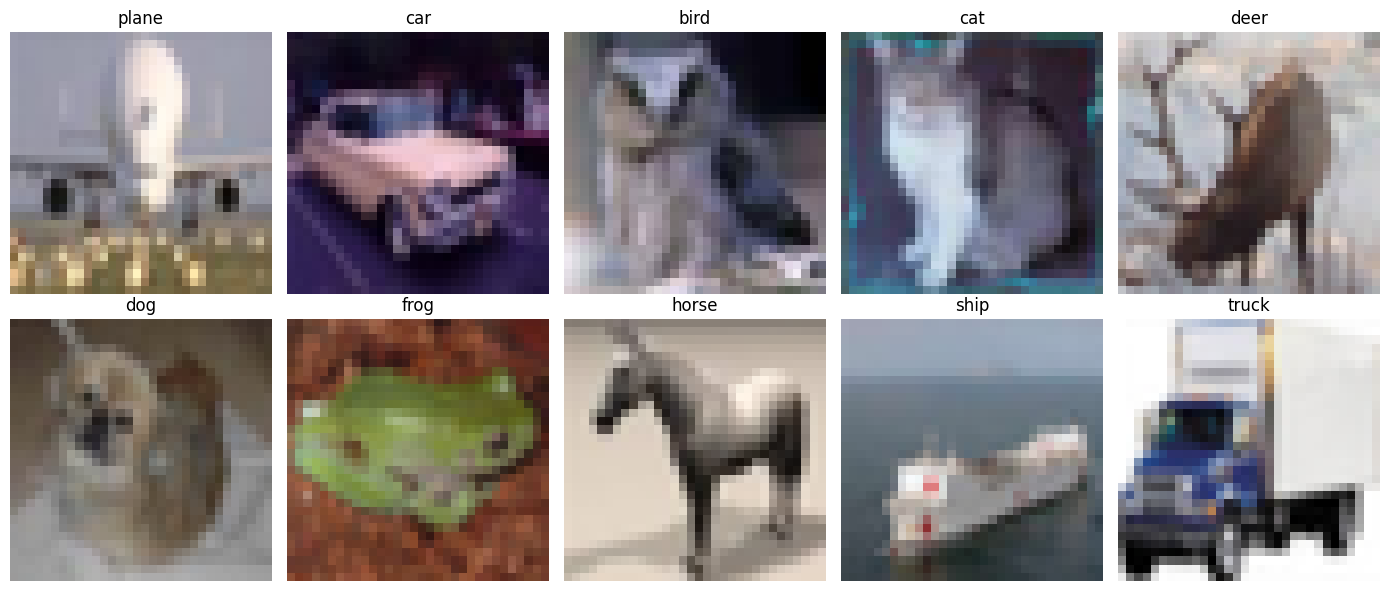

In [13]:
# Define CIFAR-10 class names
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Normalize the data to (-1, 1)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

# Load CIFAR-10
cifar10_train = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)

# Use a small subset for faster training
subset_size = 2000  # Small subset for demonstration
indices = torch.randperm(len(cifar10_train))[:subset_size]
data_subset = torch.utils.data.Subset(cifar10_train, indices)

# Display one image from each class
fig, axes = plt.subplots(2, 5, figsize=(14, 6))
axes = axes.flatten()

# Create a dictionary to track which classes we've seen
class_indices = {i: None for i in range(len(classes))}

# Find one image from each class
for idx, (image, label) in enumerate(data_subset):
    if class_indices[label] is None:
        class_indices[label] = idx
    if all(v is not None for v in class_indices.values()):
        break

# Plot one image from each class
for class_idx in range(len(classes)):
    image, label = data_subset[class_indices[class_idx]]
    # Denormalize for display: multiply by std and add mean
    image = image * 0.5 + 0.5  # undo normalization
    image = image.permute(1, 2, 0).numpy()  # Convert to HWC format
    axes[class_idx].imshow(image)
    axes[class_idx].set_title(f'{classes[label]}')
    axes[class_idx].axis('off')

plt.tight_layout()
plt.show()


**Question**: Suppose we're trying to learn a linear classifier for 10 classes that takes raw RGB pixels as input.
* What is the size of the weight matrix $W$?
* What is the size of the bias vector $b$?
* How many **parameters** does the model have?

In [14]:
data_subset[0][0].shape # an input datapoint (image)

torch.Size([3, 32, 32])

In [17]:
3 * 32 * 32

3072

## Part 2: Linear Classifier (Single-layer Neural Network)

In [20]:
# Define a simple linear classifier
class LinearClassifier(nn.Module):

    # the constructor initializes the "layers" - in this case, 
    # just one "fully connected" or linear layer
    def __init__(self, input_size=3*32*32, num_classes=10):
        super(LinearClassifier, self).__init__()
        self.fc = nn.Linear(input_size, num_classes) # our only layer
    
    def forward(self, x):
        x = x.view(x.size(0), -1) # unroll the pixels into a vector
        
        # Apply linear layer to get y (raw un-normalized scores)
        x = self.fc(x)
        return x

# Create model and move to device
linear_model = LinearClassifier().to(device)
print(f'Linear model created:')
print(linear_model)
print(f'Number of parameters: {sum(p.numel() for p in linear_model.parameters()):,}')

Linear model created:
LinearClassifier(
  (fc): Linear(in_features=3072, out_features=10, bias=True)
)
Number of parameters: 30,730


In [21]:
def train_model(model, dataset, num_epochs=10, batch_size=128, learning_rate=0.01):

    # takes care of loading data and creating batches for us
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True) 

    # calculates softmax + cross-entropy loss for us:
    loss_fn = nn.CrossEntropyLoss()

    # takes care of the gradient updates for us:
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    # we'll track some history:
    train_losses = []
    train_accuracy = []

    for epoch in range(num_epochs):
        model.train() # set model to "Train" mode
        total_loss = 0.0
        num_batches = 0
        num_correct = 0
        
        for batch_idx, (images, labels) in enumerate(loader):
            # Move data to device
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images) # compute the model outputs
            loss = loss_fn(outputs, labels) # calculate the loss
            
            # Backward pass and optimization
            optimizer.zero_grad()   # Clear old gradients
            loss.backward()         # Compute gradients
            optimizer.step()        # Update parameters
            
            total_loss += loss.item()
            num_batches += 1

            # calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            num_correct += (predicted == labels).sum().item()
        
        avg_loss = total_loss / num_batches
        train_losses.append(avg_loss)

        avg_acc = num_correct / len(dataset)
        train_accuracy.append(avg_acc)
        if epoch % 5 == 0:
            print(f'Epoch {epoch+1:2d}: Loss = {avg_loss:.4f}, Accuracy = {avg_acc:.4f}')

    return train_losses, train_accuracy

In [22]:
# Train the linear classifier

# Create model and move to device
linear_model = LinearClassifier().to(device)
print(f'Linear model created:')
print(linear_model)
print(f'Number of parameters: {sum(p.numel() for p in linear_model.parameters()):,}')

linear_train_losses, linear_train_accs = train_model(
    linear_model, data_subset, 
    num_epochs=50, 
    batch_size=128, 
    learning_rate=0.01
)

print(f'Linear Classifier - Final Accuracy: {linear_train_accs[-1]:.2f}%')

Linear model created:
LinearClassifier(
  (fc): Linear(in_features=3072, out_features=10, bias=True)
)
Number of parameters: 30,730
Epoch  1: Loss = 2.1366, Accuracy = 0.2370
Epoch  6: Loss = 1.8165, Accuracy = 0.4045
Epoch 11: Loss = 1.7216, Accuracy = 0.4425
Epoch 16: Loss = 1.6588, Accuracy = 0.4780
Epoch 21: Loss = 1.6092, Accuracy = 0.4965
Epoch 26: Loss = 1.5720, Accuracy = 0.5065
Epoch 31: Loss = 1.5368, Accuracy = 0.5215
Epoch 36: Loss = 1.5011, Accuracy = 0.5435
Epoch 41: Loss = 1.4748, Accuracy = 0.5490
Epoch 46: Loss = 1.4525, Accuracy = 0.5610
Linear Classifier - Final Accuracy: 0.56%


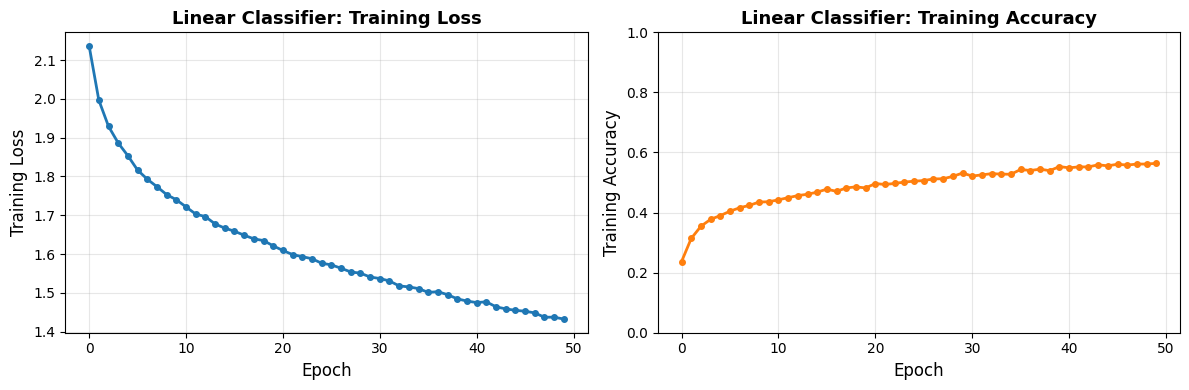

In [23]:
# Visualize linear classifier training
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1: Training loss
ax = axes[0]
ax.plot(linear_train_losses, marker='o', linewidth=2, markersize=4)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Training Loss', fontsize=12)
ax.set_title('Linear Classifier: Training Loss', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

# Plot 2: Accuracy
ax = axes[1]
ax.plot(linear_train_accs, marker='o', linewidth=2, markersize=4, color='tab:orange')
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Training Accuracy', fontsize=12)
ax.set_title('Linear Classifier: Training Accuracy', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1])

plt.tight_layout()
plt.savefig('linear_classifier_training.png', dpi=100, bbox_inches='tight')
plt.show()

## Part 3: Multi-Layer Perceptron (MLP) Classifier

In [24]:
# Define a multi-layer perceptron
class MLPClassifier(nn.Module):
    def __init__(self, input_size=3*32*32, hidden_sizes=[512, 256], num_classes=10):
        super(MLPClassifier, self).__init__()
        
        layers = []
        prev_size = input_size
        
        # Hidden layers with ReLU activation
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            prev_size = hidden_size
        
        # Output layer
        layers.append(nn.Linear(prev_size, num_classes))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        # Flatten the input
        x = x.view(x.size(0), -1)
        # Pass through network
        x = self.network(x)
        return x



In [25]:
# Create MLP model and move to device
mlp_model = MLPClassifier(input_size=3*32*32, hidden_sizes=[512, 256], num_classes=10).to(device)
print(f'MLP model created:')
print(mlp_model)
print(f'Number of parameters: {sum(p.numel() for p in mlp_model.parameters()):,}')
print('Training MLP Classifier...')
print('='*50)

# Train the MLP classifier
mlp_train_losses, mlp_train_accs = train_model(
    mlp_model, data_subset,
    num_epochs=50, 
    batch_size=128, 
    learning_rate=0.1
)

print('='*50)
print(f'MLP Classifier - Final Train Accuracy: {mlp_train_accs[-1]:.2f}%')

MLP model created:
MLPClassifier(
  (network): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
)
Number of parameters: 1,707,274
Training MLP Classifier...
Epoch  1: Loss = 2.2412, Accuracy = 0.1920
Epoch  6: Loss = 1.7231, Accuracy = 0.4160
Epoch 11: Loss = 1.4202, Accuracy = 0.5205
Epoch 16: Loss = 1.0770, Accuracy = 0.6710
Epoch 21: Loss = 0.8201, Accuracy = 0.7630
Epoch 26: Loss = 0.6024, Accuracy = 0.8270
Epoch 31: Loss = 0.4648, Accuracy = 0.8900
Epoch 36: Loss = 0.1478, Accuracy = 0.9795
Epoch 41: Loss = 0.3919, Accuracy = 0.9270
Epoch 46: Loss = 0.0446, Accuracy = 0.9990
MLP Classifier - Final Train Accuracy: 1.00%


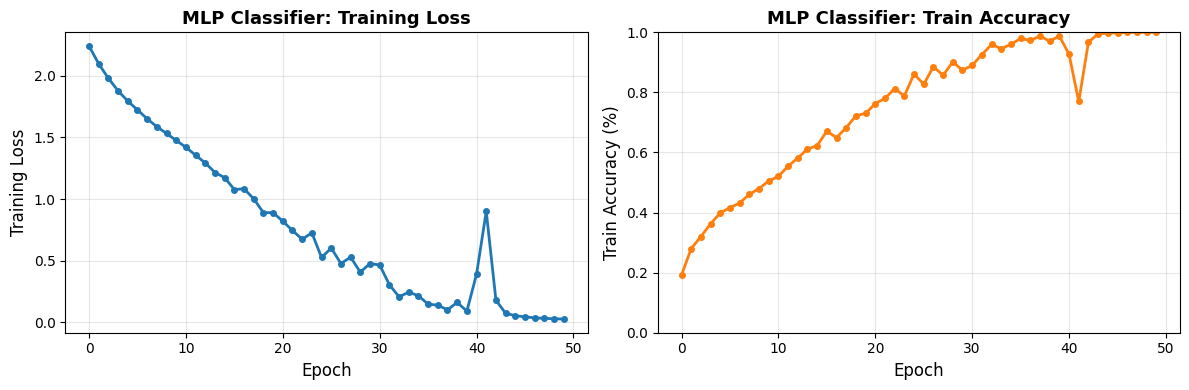

In [26]:
# Visualize MLP classifier training
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1: Training loss
ax = axes[0]
ax.plot(mlp_train_losses, marker='o', linewidth=2, markersize=4)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Training Loss', fontsize=12)
ax.set_title('MLP Classifier: Training Loss', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

# Plot 2: Train accuracy
ax = axes[1]
ax.plot(mlp_train_accs, marker='o', linewidth=2, markersize=4, color='tab:orange')
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Train Accuracy (%)', fontsize=12)
ax.set_title('MLP Classifier: Train Accuracy', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1])

plt.tight_layout()
plt.savefig('mlp_classifier_training.png', dpi=100, bbox_inches='tight')
plt.show()

## Wow, we crushed it!!

Let's see how this model does on some more CIFAR10 images!

In [27]:
# Load CIFAR-10 test data
cifar10_test = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)

# Use a small subset for faster training
subset_size = 2000  # Small subset for demonstration
indices = torch.randperm(len(cifar10_test))[:subset_size]
test_subset = torch.utils.data.Subset(cifar10_test, indices)


In [28]:

def evaluate_model(model, dataset, batch_size=128):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    model.eval()
    
    num_correct = 0
    num_samples = 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            num_correct += (predicted == labels).sum().item()
            num_samples += labels.size(0)
            
    accuracy = num_correct / num_samples
    return accuracy


In [29]:
print("Linear model evaluation accuracy:", evaluate_model(linear_model, test_subset))

Linear model evaluation accuracy: 0.348


Hmm... I thought we we had over 50% accuracy!

What about the MLP?

In [30]:
print("MLP evaluation accuracy:", evaluate_model(mlp_model, test_subset))

MLP evaluation accuracy: 0.396


uh oh...

What we're seeing here is that our models are failing to **generalize**.